In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html

import plotly.graph_objects as go

from dash.dependencies import Output,Input,State

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
#%matplotlib inline

import time

### data: mortality.org

In [2]:
path = Path('../data/mortality_org.csv')
df = pd.read_csv(path, skiprows=1)
df.head(n=3)

CountryCode  Year  Week Sex      D0_14      D15_64      D65_74      D75_84  \
0         AUT  2000     1   m   6.278031  183.721969  211.012454  237.479012   
1         AUT  2000     1   f   5.351826  100.648174  141.073418  335.405547   
2         AUT  2000     1   b  11.495527  284.504473  355.118170  573.307662   

         D85p  DTotal     R0_14    R15_64    R65_74    R75_84      R85p  \
0  175.508535   814.0  0.000467  0.003527  0.037432  0.090736  0.249625   
1  470.521035  1053.0  0.000418  0.001938  0.019563  0.060971  0.225566   
2  642.574168  1867.0  0.000438  0.002735  0.027639  0.070619  0.230392   

     RTotal  Split  SplitSex  Forecast  
0  0.010925      1         0         0  
1  0.013238      1         0         0  
2  0.012120      1         0         0

### constants and methods

In [3]:
age_groups = ['D0_14', 'D15_64', 'D65_74', 'D75_84', 'D85p', 'DTotal']

main_message ="Covid19 is not just the Flu! 10x more deadly even WITH lockdown!"
y_title = "New deaths per week"
x_title = "Week Number"

def transform_week_to_date(year, week):
    #transform this to a a string (a monday)
    iso_string = '{} {} 1'.format(year, week)
    
    #parse this to time library
    parse_iso = time.strptime(iso_string, '%Y %W %w')
    
    
    return "-".join([str(parse_iso.tm_year), 
                     str(parse_iso.tm_mon), 
                     str(parse_iso.tm_mday)])


def calc_median_mortality(df, country, age_group):
    
    mask_gender_all = df['Sex'] == 'b'
    mask_country = df['CountryCode'] == country
    
    df_country = pd.DataFrame(df[mask_country & mask_gender_all])
    
    df_median = (
        df_country.groupby('Week')
            .agg({
                age_group: np.median
            })
    )
    return df_median.rename(columns={age_group: age_group+"_median"})
    
    

def calc_extremes_mortality(df, country , age_group, n_extremes_tb_removed):
    
    mask_gender_all = df['Sex'] == 'b'
    mask_country = df['CountryCode'] == country
    
    df_country = pd.DataFrame(df[mask_country & mask_gender_all])

    week_index = []
    lower_b = []
    upper_b = []
    for gr in df_country.groupby('Week'):

        week_index.append(gr[0])
        gr_df = gr[1]


        sorted_age = gr_df[age_group].sort_values(ascending=True)

        lower_b.append( sorted_age.iloc[n_extremes_tb_removed])
        upper_b.append( sorted_age.iloc[-1-n_extremes_tb_removed])


    s1 = pd.Series(index=week_index, data=lower_b, name=age_group+'_lower').to_frame()
    s2 = pd.Series(index=week_index, data=upper_b, name=age_group+'_upper').to_frame()

    df = pd.concat([s1,s2], axis=1)
    return df

def calc_mortality_year(df, country, age_group, year):
    
    mask_gender_all = df['Sex'] == 'b'
    mask_country = df['CountryCode'] == country
    
    df_country = pd.DataFrame(df[mask_country & mask_gender_all])
    
    mask_year = df_country['Year'] == year
    
    df_year = pd.DataFrame(df_country[mask_year][[age_group, 'Week']])
        
    return df_year.set_index('Week').rename(columns={age_group: age_group+"_"+str(year)})


EVENT_DICT = {
    (2018, 8): "2018 Flu was twice as heavy as usual, ?2148?? people killed",
    (2018, 20): "Probably this is heatwaves we are looking at, which lead to higher mortality",
    (2020,12): "Week 12 was when Belgium went in lockdown"
} #year,week

In [4]:
mock_scatter = [go.Scatter(x=[1,2,3], y=[3,2,1])]
mock_layout = go.Layout()
mock_figure = go.Figure(data=mock_scatter, layout=mock_layout)

mock_graph1 = dcc.Graph(id='mock_scatter1', figure=mock_figure)
mock_graph2 = dcc.Graph(id='mock_scatter2', figure=mock_figure)


#mock_graph2 = dcc.Slider(id='mock_slider')


### data prep for buttons, dropdowns,...

In [122]:
#countries
country_labels = ["AUT", "BEL", "BGR", "CZE", "DEUTNP", "DNK", "ESP", "FIN",
"GBRTENW", "ISL", "NLD", "NOR", "PRT", "SWE", "USA"]

country_names = ["Austria", "Belgium", "Bulgaria", "Czech Republic", "Germany", "Denmark", "Spain", "Finland",
"United Kingdom", "Iceland", "Netherlands", "Norway", "Portugal", "Sweden", "United States"]

country_dict = dict(zip(country_labels, country_names))

options_country = [{'label': country_dict[c], 'value': c} for c in  df['CountryCode'].unique()]    

#years
all_years = sorted(df['Year'].unique())

options_year = [{'label': str(y), 'value': y} for y in  all_years]    
slider_marks_years = {y: str(y) for y in all_years[:10]}

min_year = all_years[0]
max_year = all_years[-1]
dict_test2 = { i: str(i)+"" for i in range(min_year,max_year+1) }


#age_groups
age_desc = ["0-14", "15-64", "65-74", "75-84", "85+", "All"]
age_groups

options_age = [{'label': d, 'value': g} for d, g in  zip(age_desc, age_groups)]    


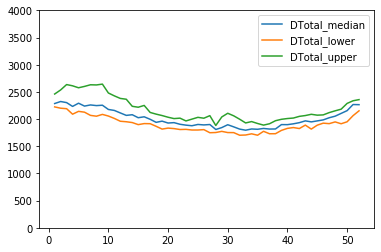

In [139]:
import plotly.offline as pyo

def draw_chart(df, country, years, age_group):
    
    #stats: median and outliers
    df_m = calc_median_mortality(df, country, age_group)
    df_ul = calc_extremes_mortality(df, country, age_group, 2)
    df_stats = pd.concat([df_m, df_ul], axis=1)
    
    #create oulier curve = line charts which encloses the conf region
    ser_below = df_stats[ age_group + '_lower']
    ser_up = df_stats.sort_index(ascending=False)[age_group +'_upper']
    ser_twist = pd.concat([ser_below, ser_up])
    
    
    trace_conf = go.Scatter(
        x=ser_twist.index,
        y=ser_twist.values,
        fill='tozerox',
        fillcolor='rgba(231,107,243,0.5)',
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="none"
    )

    trace_median = go.Scatter(
        x=df_stats.index,
        y=df_stats[age_group + '_median'],
        fillcolor='rgba(0,0,200,0.9)',
        name='median (last 30 years)',
        mode='lines',
        line={
            'width': 5
        },
        hoverinfo="y",
    )
    
    
    
    
    
    #mortality per year
    df_years = []
    year_max = []
    
    
    for y in years: 
        
        dfy = calc_mortality_year(df, country, age_group, y)
        
        year_max.append(dfy.max().values[0])

        dfy['date'] = (
            dfy
            .reset_index()['Week']
            .apply(lambda w : transform_week_to_date(y, w))
            .values #index is different!
        )
        
        df_years.append(dfy)
    
    print(str(years))
    
    year_traces = []
    for y, dfy in zip(years,df_years):
    
        trace_y = go.Scatter(
            x=dfy.index,
            y=dfy[age_group + '_' + str(y)],
            fillcolor='rgba(200,0,0,0.9)',
            name=str(y),
            mode='lines+markers',
            marker={
               "size": 10 
            },
            hoverinfo="y+text",
            hovertext=dfy['date'] 
        )
        
        year_traces.append(trace_y)
    
    
    max_val = max(year_max)
    data= [trace_conf, trace_median] + year_traces
    
    print(len(data))
    
    layout = go.Layout({
        'xaxis': {
            'title_text': 'week',
            'range': [1,50],
            'showspikes': True,
            'spikethickness': 1,
            'spikecolor': 'black'
        },
        'yaxis': {
            'title_text': 'deaths per week',
            'range': [0,max_val+100],
            'showspikes': True,
            'spikethickness': 1,
            'spikecolor': 'black'
        }

    })
    
    
    return go.Figure(data=data, layout=layout)



fig = draw_chart(df, "BEL", [2020], "DTotal")
#pyo.iplot(fig);

CountryCode  Year  Week Sex  D0_14  D15_64  D65_74  D75_84    D85p  \
3174         BEL  2000     1   m    9.0   277.0   354.0   449.0   291.0   
3175         BEL  2000     1   f    9.0   165.0   186.0   432.0   642.0   
3176         BEL  2000     1   b   18.0   442.0   540.0   881.0   933.0   
3177         BEL  2000     2   m    9.0   276.0   319.0   458.0   312.0   
3178         BEL  2000     2   f   11.0   150.0   175.0   412.0   639.0   
...          ...   ...   ...  ..    ...     ...     ...     ...     ...   
6346         BEL  2020    18   f    2.0   112.0   148.0   295.0   748.0   
6347         BEL  2020    18   b    5.0   281.0   367.0   636.0  1104.0   
6348         BEL  2020    19   m    3.0   175.0   238.0   327.0   365.0   
6349         BEL  2020    19   f    1.0   108.0   113.0   303.0   707.0   
6350         BEL  2020    19   b    4.0   283.0   351.0   630.0  1072.0   

      DTotal     R0_14    R15_64    R65_74    R75_84      R85p    RTotal  \
3174  1380.0  0.000507  0.004255  0.041699  0.109392  0.312227  0.014319   
3175  1434.0  0.000531  0.002571  0.018083  0.065032  0.240234  0.014235   
3176  2814.0  0.000519  0.003419  0.028761  0.081974  0.258850  0.014276   
3177  1374.0  0.000507  0.004240  0.037576  0.111585  0.334759  0.014257   
3178  1387.0  0.000649  0.002337  0.017014  0.062022  0.239112  0.013768   
...      ...       ...       ...       ...       ...       ...       ...   
6346  1305.0  0.000110  0.001601  0.012448  0.038445  0.173980  0.011652   
6347  2393.0  0.000134  0.001991  0.016086  0.046964  0.170784  0.010822   
6348  1108.0  0.000158  0.002460  0.021785  0.055719  0.168595  0.010154   
6349  1232.0  0.000055  0.001543  0.009504  0.039487  0.164444  0.011000   
6350  2340.0  0.000108  0.002005  0.015385  0.046521  0.165834  0.010583   

      Split  SplitSex  Forecast  
3174      0         0         0  
3175      0         0         0  
3176      0         0         0  
3177      0         0         0  
3178      0         0         0  
...     ...       ...       ...  
6346      0         0         1  
6347      0         0         1  
6348      0         0         1  
6349      0         0         1  
6350      0         0         1  

[3177 rows x 19 columns]

In [140]:
#buttons
add_button = html.Button('Add', id='add-button')
reset_button = html.Button('Reset', id='reset-button')
play_button = html.Button('Play', id='play-button', style={'margin': "10px"})

#dropdowns


country_dropdown = dcc.Dropdown(
    options=options_country,
    value='BEL'
)  

year_dropdown = dcc.Dropdown(
    options=options_year,
    value=2020
)  

age_dropdown = dcc.Dropdown(
    options=options_age,
    value="DTotal"
)  


#sliders
mock_slider = dcc.Slider(
    min=1990,
    max=2020,
    step=None,
    marks=dict_test2,
    value=5
)  


#grah

graph = dcc.Graph(id='plot', figure=draw_chart(df, "BEL", [2000,2015,2018,2019,2020], "DTotal"))


In [141]:
app = dash.Dash()

div_style = {
    
}



mock_div = html.Div(id="row_1", children=[],
                        style={
                            "border": "2px solid green", 
                            "height": "500px", "width": "100%",
                            "overflow": "hidden"
                        }
                    )

mock_div_slider = html.Div(id='row_2', children=[html.H4("Play through the consecutive years")],
                        style={"border": "2px solid pink", 
                               'height': '100px', 'width':"98%",
                               'padding-left': '1%', 'padding-right': '1%'

                              }
                          )



mock_div_a  = html.Div(id='chart_1' , 
                       children=[graph], 
                       style={"border": "2px solid blue", 
                              'height': '100%', 'width':"75%", 
                              'float': "left"}
                      )

mock_div_b  = html.Div(id='row_1b' , 
                       children=[], 
                       style={"border": "2px solid yellow", 
                              'height': '100%', 'width':"24%", 
                              'float': "left",
                              'padding': "2px"
                             }
                      )

mock_div.children.append(mock_div_a)
mock_div.children.append(mock_div_b)





mock_div_ba = html.Div(id='country_selector_1', 
                       children=[html.H4('Select country')], 
                       style={"border": "2px solid red", 'height': '33%', 'width':"99%"}
                      )



mock_div_bb = html.Div(id='add_reset_year_1', 
                       children=[html.H4('Add/Reset years shown')],
                       style={"border": "2px solid black", 'height': '33%', 'width':"99%" }
                      )


mock_div_bc = html.Div(id='select_age_1', 
                       children=[html.H4('Select age group')],
                       style={"border": "2px solid purple", 'height': '33%', 'width':"99%" }
                      )

mock_div_b.children.append(mock_div_ba)
mock_div_b.children.append(mock_div_bb)
mock_div_b.children.append(mock_div_bc)


#add dropdowns
                      
mock_div_ba.children.append(country_dropdown)
mock_div_bb.children.append(year_dropdown)
mock_div_bc.children.append(age_dropdown)

#add slider
mock_div_slider.children.append(mock_slider)

In [91]:
app.layout = html.Div([
    html.H1('Unbiased COVID19 analysis'),
    html.H3('Unbiased? Study Mortality!'),
    mock_div,
    mock_div_slider
], 
    style=div_style
)

In [6]:
if __name__ == '__main__':
    app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Debugger PIN: 478-155-121
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [151]:

!jupyter nbconvert --to python Covid_dashboard_window1-dash.ipynb



[NbConvertApp] Converting notebook Covid_dashboard_window1-dash.ipynb to python
[NbConvertApp] Writing 10805 bytes to Covid_dashboard_window1-dash.py
